## ECE495 Programming neurons with Nengo: Advanced Examples

In this demonstration we will:

1. Perform matrix multiplication with greater than 2-dimensional neurons
2. Create a delay using nodes
3. Learn decoders in real-time

#### Set up

**Ensure you are using your [495 Virtual Environment](https://github.com/kaitlin-fair/495venv_setup) before you begin!**  
    
Import Nengo and other supporting libraries into your program to get started:

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import nengo
from nengo.processes import Piecewise
from nengo.processes import WhiteSignal
from nengo.solvers import LstsqL2

### Matrix Multiplication

This example demonstrates how to perform general matrix multiplication using Nengo. The matrix can change during the computation, which makes it distinct from doing static matrix multiplication with neural connection weights (as done in all neural networks).

Let's compute $A \cdot B$, which is equal to $(B \cdot A)^T$ where

$A = \begin{bmatrix}
		.5 & -.5 \\
		-.2 & .3  
	\end{bmatrix}$  and  $B = 	\begin{bmatrix}
									.58 & -1 \\
									.7 & .1  
								\end{bmatrix}$

Big differences here:
- We are using an _EnsembleArray_ (i.e. an array of ensembles of neurons) instead of an _Ensemble_ of neurons
- We specifically _probe the outputs of an Ensemble Array_ since we need to probe each ensemble's output (not the array itself). This results in 4 outputs since we have an array of 4 ensembles of neurons



In [2]:
Amat = np.array([[0.5, -0.5], [-0.2, 0.3]])
Bmat = np.array([[0.58, -1.0], [0.7, 0.1]])

model = nengo.Network(label="Matrix Multiplication", seed=123)
with model:
    # Make 2 EnsembleArrays to encode the input
    # Amat.size and Bmat.size = 4, therefore 4D neurons used
    # Values should stay within the range (-radius, radius)
    A = nengo.networks.EnsembleArray(n_neurons = 100, n_ensembles=Amat.size, radius=1) 
    B = nengo.networks.EnsembleArray(n_neurons = 100, n_ensembles=Bmat.size, radius=1)

    # Create 2 nodes to send in matrix values
    inputA = nengo.Node(Amat.ravel())  # ravel is equivalent to reshape(-1) i.e. flatten!
    inputB = nengo.Node(Bmat.ravel())

    # connect input nodes to neuron ensembles
    nengo.Connection(inputA, A.input) ############################## You have to specify inputA instead of just saying A bc now its an array instead of just and ensamble
    nengo.Connection(inputB, B.input)

    # Probe to check we've connected correctly
    #  Note: must probe the output of each ensemble because 
    #        we are using an array of ensembles!
    #
    # sample_every determines how many timesteps you plot
    #  in this case, it's fewer times than the simulation would plot
    # default simulation dt = .001
    A_probe = nengo.Probe(A.output, sample_every=0.01, synapse=0.01) # You have to specify A.output instead of just saying A bc now its an array instead of just and ensamble
    B_probe = nengo.Probe(B.output, sample_every=0.01, synapse=0.01)

#### Run and Plot

Build finished in 0:00:01.                                                      
Simulation finished in 0:00:01.                                                 


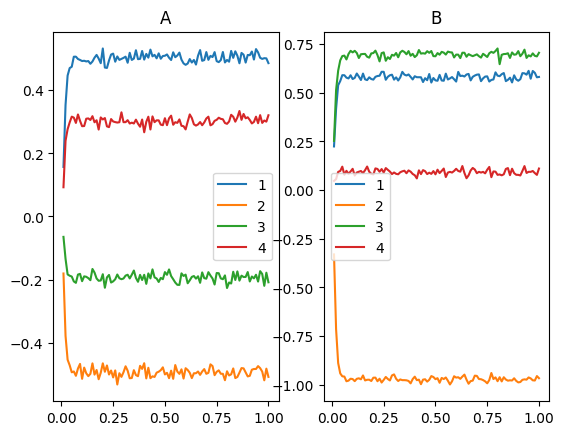

In [3]:
with nengo.Simulator(model) as sim:
    sim.run(1)
    
plt.figure()
plt.subplot(1, 2, 1)
plt.title("A")
plt.plot(sim.trange(sample_every=0.01), sim.data[A_probe])
plt.legend(['1','2','3','4'], loc="best")

plt.subplot(1, 2, 2)
plt.title("B")
plt.plot(sim.trange(sample_every=0.01), sim.data[B_probe])
plt.legend(['1','2','3','4'], loc="best")

Inputs look good, but now we need to actually perform each multiplication that occurs in matrix multiplication. 

First, we will use one of Nengo's reusable networks `product` instead of manually creating multiplication neurons as we did in `neuron_transformations.ipynb` (although we could definitely do it this way!). The `product` network computes the element-wise product of two equally sized vectors where `input_a` is the first vector and `input_b` is the second. Read more about different reusable networks [here](https://www.nengo.ai/nengo/networks.html#nengo.networks.Product).

You'll notice we call an argument `transform`. It's way easier to use transform than a function when it comes to matrix multiplication!

In [4]:
with model:
    # The C matrix is composed of populations that each contain
    # one element of A and one element of B.
    # These elements will be multiplied together in the next step.

    # For two 2x2 matrices to be multiplied together, there will be 
    #  8 total multiplications that will occur (think through this!)
    c_size = Amat.size * Bmat.shape[1] # 4*2 = 8
    C = nengo.networks.Product(100, dimensions=c_size) ###There is where the Product thing is used which = instead of maunally multiplying matirx its gonna do it for us. 

# Determine the transformation matrices to get the correct pairwise
#   products computed. 
transformA = np.zeros((c_size, Amat.size))
transformB = np.zeros((c_size, Bmat.size))

for i in range(Amat.shape[0]):
    for j in range(Amat.shape[1]):
        for k in range(Bmat.shape[1]):
            c_index = j + k * Amat.shape[1] + i * Bmat.size
            transformA[c_index][j + i * Amat.shape[1]] = 1
            transformB[c_index][k + j * Bmat.shape[1]] = 1

print("A->C")
print(transformA)
print("B->C")
print(transformB)

with model:
    conn = nengo.Connection(A.output, C.input_a, transform=transformA)
    nengo.Connection(B.output, C.input_b, transform=transformB)
    C_probe = nengo.Probe(C.output, sample_every=0.01, synapse=0.01)

A->C
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
B->C
[[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]]


We printed the weights. Recall, we have two 2x2 matrices. Each matrix was flattened into an array of 4 values (indices 0 to 3). If there is a `1` in the tranform matrix, that means the element is "active" because it is weighted 1 instead of 0. So, for the first multiplication that must be performed, we have $a_0$ multiplied by $b_0$.

If you take a look at each transform matrix row by row, they line up to perform each multiplication required within two 2x2 matrices being multiplied. 

$$ \vec{A} \vec{B}  
=
\begin{bmatrix} 
	a_{11} & a_{12} \\
	a_{21} & a_{22}  
\end{bmatrix}
\begin{bmatrix} 
	b_{11} & b_{12} \\
	b_{21} & b_{22}  	
\end{bmatrix}
=
\begin{bmatrix} 
	a_{0} & a_{1} \\
	a_{2} & a_{3}  
\end{bmatrix}
\begin{bmatrix} 
	b_{0} & b_{1} \\
	b_{2} & b_{3}  	
\end{bmatrix}
\\ 
=
\begin{bmatrix} 
	a_{11}  b_{11} + a_{12}b_{21} & a_{11} b_{12}+a_{12}b_{22} \\
	a_{21}  b_{11} + a_{22}b_{21} & a_{21}  b_{12} + a_{22}b_{22} 	
\end{bmatrix} 
=
\begin{bmatrix} 
	a_{0}  b_{0} + a_{1}b_{2} & a_{0} b_{1}+a_{1}b_{3} \\
	a_{2}  b_{0} + a_{3}b_{2} & a_{2}  b_{1} + a_{3}b_{3} 	
\end{bmatrix} $$

Now, let's view the outputs of our 8-dimensional neuron ensemble C (created from a pre-built Nengo network `product`). This will output each of the individual multiplications. Note: no addition has occurred!

Build finished in 0:00:01.                                                      
Simulation finished in 0:00:01.                                                 


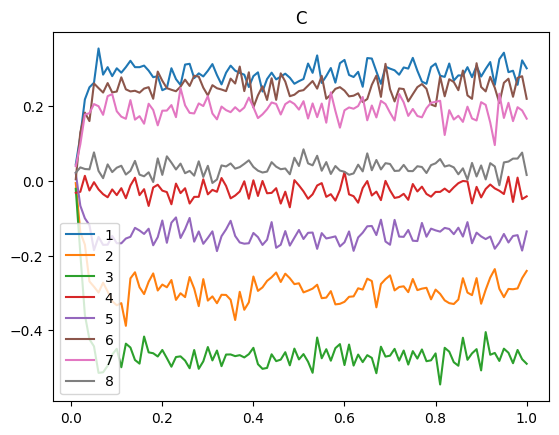

In [5]:
# Run it!
with nengo.Simulator(model) as sim:
    sim.run(1)

# Plot it!
plt.figure()
plt.plot(sim.trange(sample_every=0.01), sim.data[C_probe]) ### 0.001 is nengos default time step... thats a lot so we are changing sample to every 0.01 instead.
plt.title("C")
plt.legend(['1','2','3','4','5','6','7','8'], loc="best")

Now we have to add the appropriate elements to complete matrix multiplication. We use the same `transform` argument (i.e. decoders/weights) to choose which of the outputs from C should be added together. 

In [6]:
with model:
    # Now do the appropriate summing
    D = nengo.networks.EnsembleArray(
        100, n_ensembles=Amat.shape[0] * Bmat.shape[1], radius=1
    ) # sanity check that this is the right size for any matrix multiplication!

# The mapping for this transformation is much easier, since we want to
# combine pairs from C within D.
transformC = np.zeros((D.dimensions, c_size))
for i in range(c_size):
    transformC[i // Bmat.shape[0]][i] = 1
print("C->D")
print(transformC)

with model:
    nengo.Connection(C.output, D.input, transform=transformC)
    D_probe = nengo.Probe(D.output, sample_every=0.01, synapse=0.01)

C->D
[[1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1.]]


We have 8 outputs from C. We add two at a time to compute the four outputs of our two 2x2 matrices being multiplied together.

Recall:
$$ \vec{A} \vec{B}  
=
\begin{bmatrix} 
	a_{11} & a_{12} \\
	a_{21} & a_{22}  
\end{bmatrix}
\begin{bmatrix} 
	b_{11} & b_{12} \\
	b_{21} & b_{22}  	
\end{bmatrix}
=
\begin{bmatrix} 
	a_{0} & a_{1} \\
	a_{2} & a_{3}  
\end{bmatrix}
\begin{bmatrix} 
	b_{0} & b_{1} \\
	b_{2} & b_{3}  	
\end{bmatrix}
\\ 
=
\begin{bmatrix} 
	a_{11}  b_{11} + a_{12}b_{21} & a_{11} b_{12}+a_{12}b_{22} \\
	a_{21}  b_{11} + a_{22}b_{21} & a_{21}  b_{12} + a_{22}b_{22} 	
\end{bmatrix} 
=
\begin{bmatrix} 
	a_{0}  b_{0} + a_{1}b_{2} & a_{0} b_{1}+a_{1}b_{3} \\
	a_{2}  b_{0} + a_{3}b_{2} & a_{2}  b_{1} + a_{0}b_{3} 	
\end{bmatrix} $$

Now, let's run it and see our final answer!

Build finished in 0:00:01.                                                      
Simulation finished in 0:00:01.                                                 


Text(0.5, 1.0, 'D')

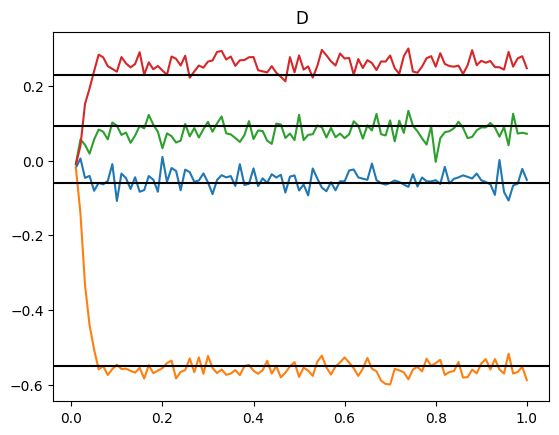

In [7]:
# Run it!
with nengo.Simulator(model) as sim:
    sim.run(1)

# Plot it!
plt.figure()
plt.plot(sim.trange(sample_every=0.01), sim.data[D_probe])
for d in np.dot(Amat, Bmat).flatten():
    plt.axhline(d, color="k")
plt.title("D")

#### Discussion

We could have written matrix multiplication manually using our own multiplication function from last time. That may have made it more intuitive, and we could have possibly found a faster way to do it! 

BUT, now you have experience using a pre-built Nengo network and a generalized form of matrix multiplication, which may come in handy for your final project.

### Delays using Nengo Nodes

We can use a Nengo node to implement an n-timestep delayed connection by using a node. Why might you want a delay? Recall our bubblesort outputs. They were not precise as we had expected because of some of the feedback delays due to calculations. We may want to send something in at the exact same time to prevent this (or explore dynamics to adjust for the delays - both options have pros/cons!). Ultimately, you may want to wait to send an input into a neuron for a variety of reasons and this code will help you make that happen.

This example uses object-oriented programming to set up the delay. You can find a pretty good tutorial on the topic [here](https://www.udacity.com/blog/2021/11/__init__-in-python-an-overview.html). You can also see how `np.roll` works [here](https://numpy.org/doc/stable/reference/generated/numpy.roll.html).

The class `Delay` starts off with an array called `self.history` of 250 zeros (each time step is `dt=.001` seconds and we want a `time_delay=25` seconds, which is in total 250 time steps). For the first actual time step of the system ($t=1$), the `self.history` array updates to $\begin{bmatrix} 0 & 0 & ... & x(1) \end{bmatrix}$, but what leaves the node is the first element of the array, 0. This is what we want! We are delaying our signal while storing what will come 250 timesteps later. At the next time step ($t=2$), the `self.history` array updates to $\begin{bmatrix} 0 & 0 & ... & x(1) & x(2) \end{bmatrix}$. Keep going until time step $t=250$ and you should get the `self.history` array $\begin{bmatrix} x(1) & x(2) & ... & x(249) & x(250) \end{bmatrix}$ and the first element $x(1)$ is what leaves the node. That means at time step 250, you're just now seeing the start of the original signal, i.e. you've delayed the signal by 250 timesteps!



In [8]:
model = nengo.Network(label="Delayed connection")
with model:
    # We'll use white noise as input
    inp = nengo.Node(WhiteSignal(2, high=5), size_out=1)
    A = nengo.Ensemble(40, dimensions=1)
    nengo.Connection(inp, A)


# We'll make a simple object to implement the delayed connection
class Delay:
    def __init__(self, dimensions, timesteps=50):
        self.history = np.zeros((timesteps, dimensions))

    def step(self, t, x):
        self.history = np.roll(self.history, -1)
        self.history[-1] = x
        return self.history[0]

dt = 0.001 # default nengo timestep
time_delay = .25 # seconds by which you wish to delay the signal
delay = Delay(1, timesteps=int(time_delay / dt))

with model:
    delaynode = nengo.Node(delay.step, size_in=1, size_out=1)
    nengo.Connection(A, delaynode)

    # Send the delayed output through an ensemble
    B = nengo.Ensemble(40, dimensions=1)
    nengo.Connection(delaynode, B)

    # Probe the input at the delayed output
    A_probe = nengo.Probe(A, synapse=0.01)
    B_probe = nengo.Probe(B, synapse=0.01)

Run it and plot it

Build finished in 0:00:01.                                                      
Simulation finished in 0:00:01.                                                 


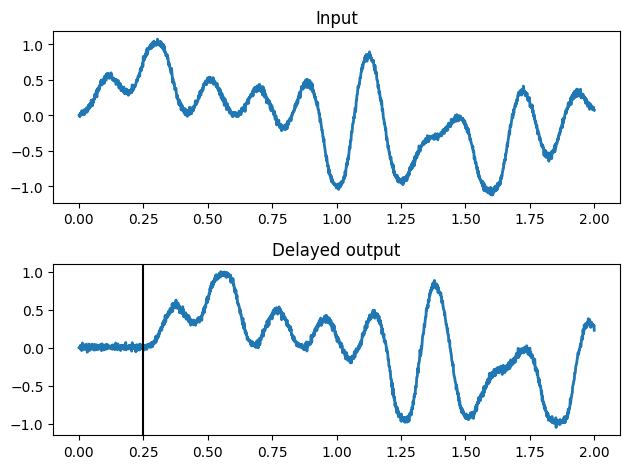

In [9]:
# Run for 2 seconds
with nengo.Simulator(model) as sim:
    sim.run(2)

# Plot the results
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(sim.trange(), sim.data[A_probe], lw=2)
plt.title("Input")
plt.subplot(2, 1, 2)
plt.plot(sim.trange(), sim.data[B_probe], lw=2)
plt.axvline(time_delay, c="k")
plt.title("Delayed output")
plt.tight_layout()


### Online Learning

Normally, if you have a function you would like to compute across a connection, you would specify it with `function` in the Connection constructor. However, it is also possible to use error-driven learning to learn to compute a function online (i.e. while you're actively receiving inputs). This is relevant to _edge computing_ which we discussed quite a bit in our Neuroscience and Neural Nets lectures. Suppose you've trained a DNN to classify certain data, but now you get new data while in the field and want to update your network in real-time. This is NOT an easy task with current state of the art - in fact a lot of dollars are going in to trying to solve this problem. Our brains however have already solved it. These neurons are inspired by our brains. So let's learn in real time with these neurons.

First, here's our model without learning - i.e. Nengo computes all of the weights for the connections in advance. In this case, we have two ensembles acting as a communication channel (we built a simple version of this in `neuron_transformations.ipynb`). In a comms channel, you want the output of the first ensemble fed into the second, and you want the second ensemble's output to match that of the original input.

[Input] ---> (A) ---> (B) ---> [Output]

To demonstrate online learning, we add in a function between the two ensembles (i.e. the output of the second ensemble is a function of the first - which is why we have weights, to compute that f(x)). NOTE: in a comms channel, our f(x) = x. BUT we want to mess that up so we have to relearn the weights to make that happen. SO, we add a weird function in between that we will train away by the end of this demo. 

Notice both ensembles are 2D - meaning we send two white noise signals into the two inputs of the first ensemble, and we get a white noise signal out of the two output dimensions. THEN, we compute a bizarre function where we just return two random numbers out of the second ensemble. To recap: we send two white noise signals into Ensemble A, connect to Ensemble B, which then outputs two random values from the network using pretrained Nengo decoders.



Build finished in 0:00:01.                                                      
Simulation finished in 0:00:02.                                                 


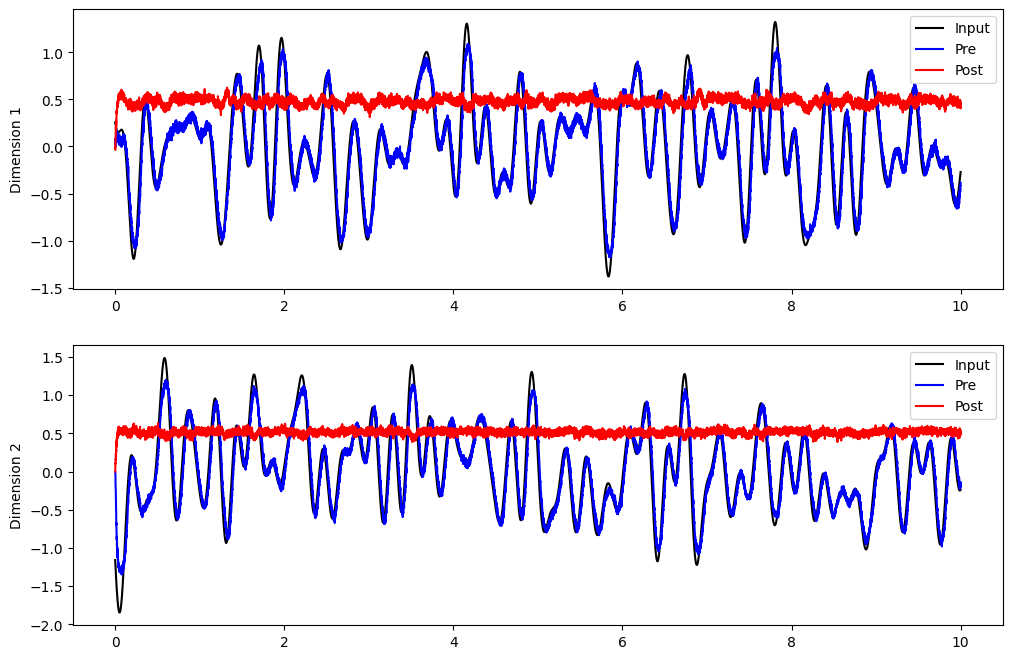

In [80]:
model = nengo.Network(label="Pretrained Comms Channel")
with model:
    # input signal, passed from node to ensemble A
    input = nengo.Node(WhiteSignal(60, high=5), size_out=2)
    A = nengo.Ensemble(60, dimensions=2)
    nengo.Connection(input, A)

    # passed output of ensemble A to ensemble B 
    # train weights with a complicated function (send in a value, return something random)
    B = nengo.Ensemble(60, dimensions=2)
    conn = nengo.Connection(A, B, function=lambda x: np.random.random(2))
    
    inp_p = nengo.Probe(input)
    pre_p = nengo.Probe(A, synapse=0.01)
    post_p = nengo.Probe(B, synapse=0.01)

with nengo.Simulator(model) as sim:
    sim.run(10.0)

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(sim.trange(), sim.data[inp_p].T[0], c="k", label="Input")
plt.plot(sim.trange(), sim.data[pre_p].T[0], c="b", label="Pre")
plt.plot(sim.trange(), sim.data[post_p].T[0], c="r", label="Post")
plt.ylabel("Dimension 1")
plt.legend(loc="best")
plt.subplot(2, 1, 2)
plt.plot(sim.trange(), sim.data[inp_p].T[1], c="k", label="Input")
plt.plot(sim.trange(), sim.data[pre_p].T[1], c="b", label="Pre")
plt.plot(sim.trange(), sim.data[post_p].T[1], c="r", label="Post")
plt.ylabel("Dimension 2")
plt.legend(loc="best")



#### Add in Learning

Now, we will add an ensemble to compute our error. We know that with a proper comms channel, our output from the ensemble B should match that of ensemble A. The error is therefore the difference between the two and we will use an ensemble to compute that. The error neuron will subtract ensemble A output from ensemble B output using the `transform=-1` argument for the A connection(i.e. error $= B-A =$ how far off we are from where we want to be).

We will then employ an error rule on our connection between A and B, which we called `conn` in the last segment of code. The learning rule we use is called the [prescribed error sensitivity (PES) learning rule](https://www.researchgate.net/publication/282366687_A_Solution_to_the_Dynamics_of_the_Prescribed_Error_Sensitivity_Learning_Rule). The PES learning rule is a biologically plausible supervised learning rule that is frequently used with the Neural Engineering Framework (NEF) -- this is Nengo's framework! PES modifies the connection weights between populations of neurons to minimize an external error signal (being the error ensemble we've created). [This page](https://www.nengo.ai/nengo/examples/learning/learn-communication-channel.html) describes it succinctly in the "How does this work?" section if you want the math behind how the decoders are updated. 

This means we compute an error and use that in our learning rule between ensembles A and B to push the weights toward a solution where $B-A=0$, i.e. $A=B$.



In [81]:
with model:
    error = nengo.Ensemble(60, dimensions=2)
    error_probe = nengo.Probe(error, synapse=0.03)

    # Error = actual - target = post - pre
    nengo.Connection(B, error)
    nengo.Connection(A, error, transform=-1)

    # Add the learning rule to the connection
    conn.learning_rule_type = nengo.PES()

    # Connect the error into the learning rule
    nengo.Connection(error, conn.learning_rule)

    # probe the decoders to see how those change over time to reduce error
    weights_p = nengo.Probe(conn, "weights", synapse=0.01, sample_every=0.01)

#### Run it, plot it.

Build finished in 0:00:01.                                                      
Simulation finished in 0:00:02.                                                 


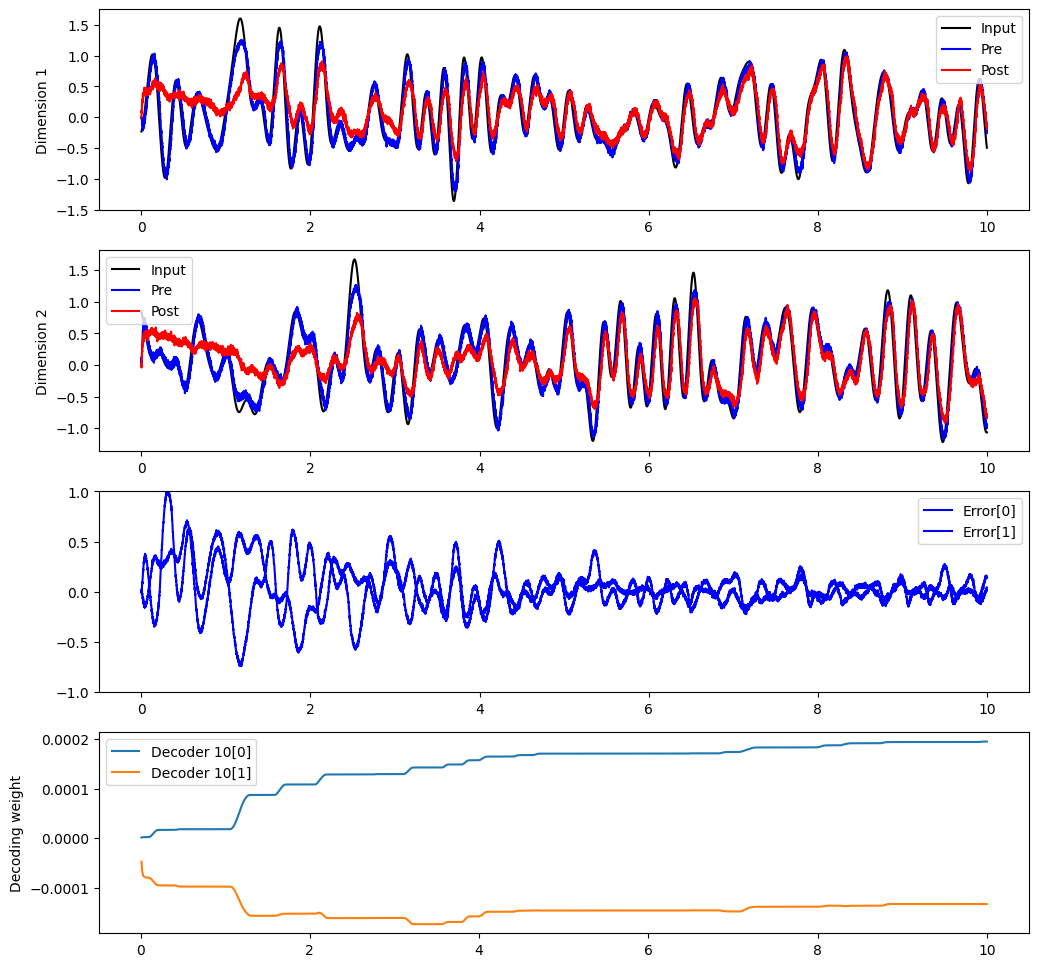

In [83]:
with nengo.Simulator(model) as sim:
    sim.run(10.0)

plt.figure(figsize=(12, 12))
plt.subplot(4, 1, 1)
plt.plot(sim.trange(), sim.data[inp_p].T[0], c="k", label="Input")
plt.plot(sim.trange(), sim.data[pre_p].T[0], c="b", label="Pre")
plt.plot(sim.trange(), sim.data[post_p].T[0], c="r", label="Post")
plt.ylabel("Dimension 1")
plt.legend(loc="best")
plt.subplot(4, 1, 2)
plt.plot(sim.trange(), sim.data[inp_p].T[1], c="k", label="Input")
plt.plot(sim.trange(), sim.data[pre_p].T[1], c="b", label="Pre")
plt.plot(sim.trange(), sim.data[post_p].T[1], c="r", label="Post")
plt.ylabel("Dimension 2")
plt.legend(loc="best")
plt.subplot(4, 1, 3)
plt.plot(sim.trange(), sim.data[error_probe], c="b")
plt.ylim(-1, 1)
plt.legend(("Error[0]", "Error[1]"), loc="best")
plt.subplot(4, 1, 4)
plt.plot(sim.trange(sample_every=0.01), sim.data[weights_p][..., 10])
plt.ylabel("Decoding weight")
plt.legend(("Decoder 10[0]", "Decoder 10[1]"), loc="best")

#### Discussion

We can see here that toward the end of our simulation, both dimensions start to look the same. We can see from the third plot that error is reduced as we go in each dimension. Once error is reduced to near zero, the weights should always work, regardless of input to the network (i.e. if we keep those decoders between those two ensembles, we can feed in any input and we should output the same signal). How? Decoders! You can see in the fourth plot how the decoders change and then converge to a value over time. That means that instead of computing that nasty random output function, the weights have adjusted to take the same output spikes and compute $f(x)=x$. If you're lost, please work back through the `neuron_transformations.ipynb`.